In [1]:
import pandas as pd
import numpy as np
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

def sigmoid(x):
    return 1/(1 +np.exp(-x))

In [9]:
test_targets = None
train_targets = None

with h5py.File("../data/images.h5", "r") as fo:
    train_targets = np.array(fo["train_targets"])
    test_targets = np.array(fo["test_targets"])

In [10]:
train_latent = np.load("../drawing/latent/train_latent.npy")
test_latent = np.load("../drawing/latent/test_latent.npy")
reconst = np.load("../drawing/train_reconst.npy")

In [12]:
print(train_latent.shape)
print(train_targets.shape)

(10, 2150, 10)
(2151,)


In [5]:
n_train = train_latent.shape[1]
n_test = test_latent.shape[1]

train_targets = train_targets[:n_train]
test_targets = test_targets[:n_test]

In [17]:
where_zero = np.where(train_targets == 0)[0]
where_one = np.where(train_targets == 1)[0]
where_two = np.where(train_targets == 2)[0]

In [30]:
n_zero = where_zero.shape[0]
dist_mat = np.zeros((n_zero, n_zero))

for i in range(n_zero):
    for j in range(i,n_zero):
        img1 = sigmoid(reconst[-1, i, :])
        img2 = sigmoid(reconst[-1, j, :])
        dist_mat[i, j] = np.sum(np.abs(img1-img2))

In [39]:
pairs = []

for i in range(n_zero):
    for j in range(i+1, n_zero):
        pairs.append([i, j])
        

pairs.sort(key = lambda pair: dist_mat[pair[0], pair[1]])

In [75]:
ref = where_zero[30]
for i, pair in enumerate(pairs):
    if ref in pair:
        print(i, pair, dist_mat[pair[0], pair[1]])
    

1923 [109, 126] 125.91390946116942
8981 [126, 199] 203.44326001586188
10279 [78, 126] 213.15207711327218
11184 [51, 126] 219.42752938787612
11361 [126, 269] 220.63761223803112
11532 [126, 338] 221.82020183079638
11997 [126, 359] 224.71042461186772
12100 [126, 293] 225.32233883588117
12325 [126, 420] 226.6543194139228
12329 [126, 448] 226.70620780948786
13220 [126, 198] 232.55931512225715
13263 [9, 126] 232.81497613660844
13298 [126, 158] 233.05394363075962
13327 [126, 214] 233.23106756469235
13501 [72, 126] 234.36708322176216
13689 [112, 126] 235.54967909984322
13808 [126, 239] 236.13598993567237
14656 [126, 373] 241.45223569831464
14727 [94, 126] 241.86922703154596
14923 [126, 370] 243.07394872772045
14952 [126, 375] 243.2476260834566
14975 [126, 128] 243.3914630208265
14979 [126, 248] 243.41112510087618
14987 [126, 381] 243.45369919587796
15704 [126, 539] 247.55060546466785
15898 [126, 364] 248.67151769526933
16571 [126, 327] 252.47780062002067
16636 [126, 343] 252.83225205582613
170

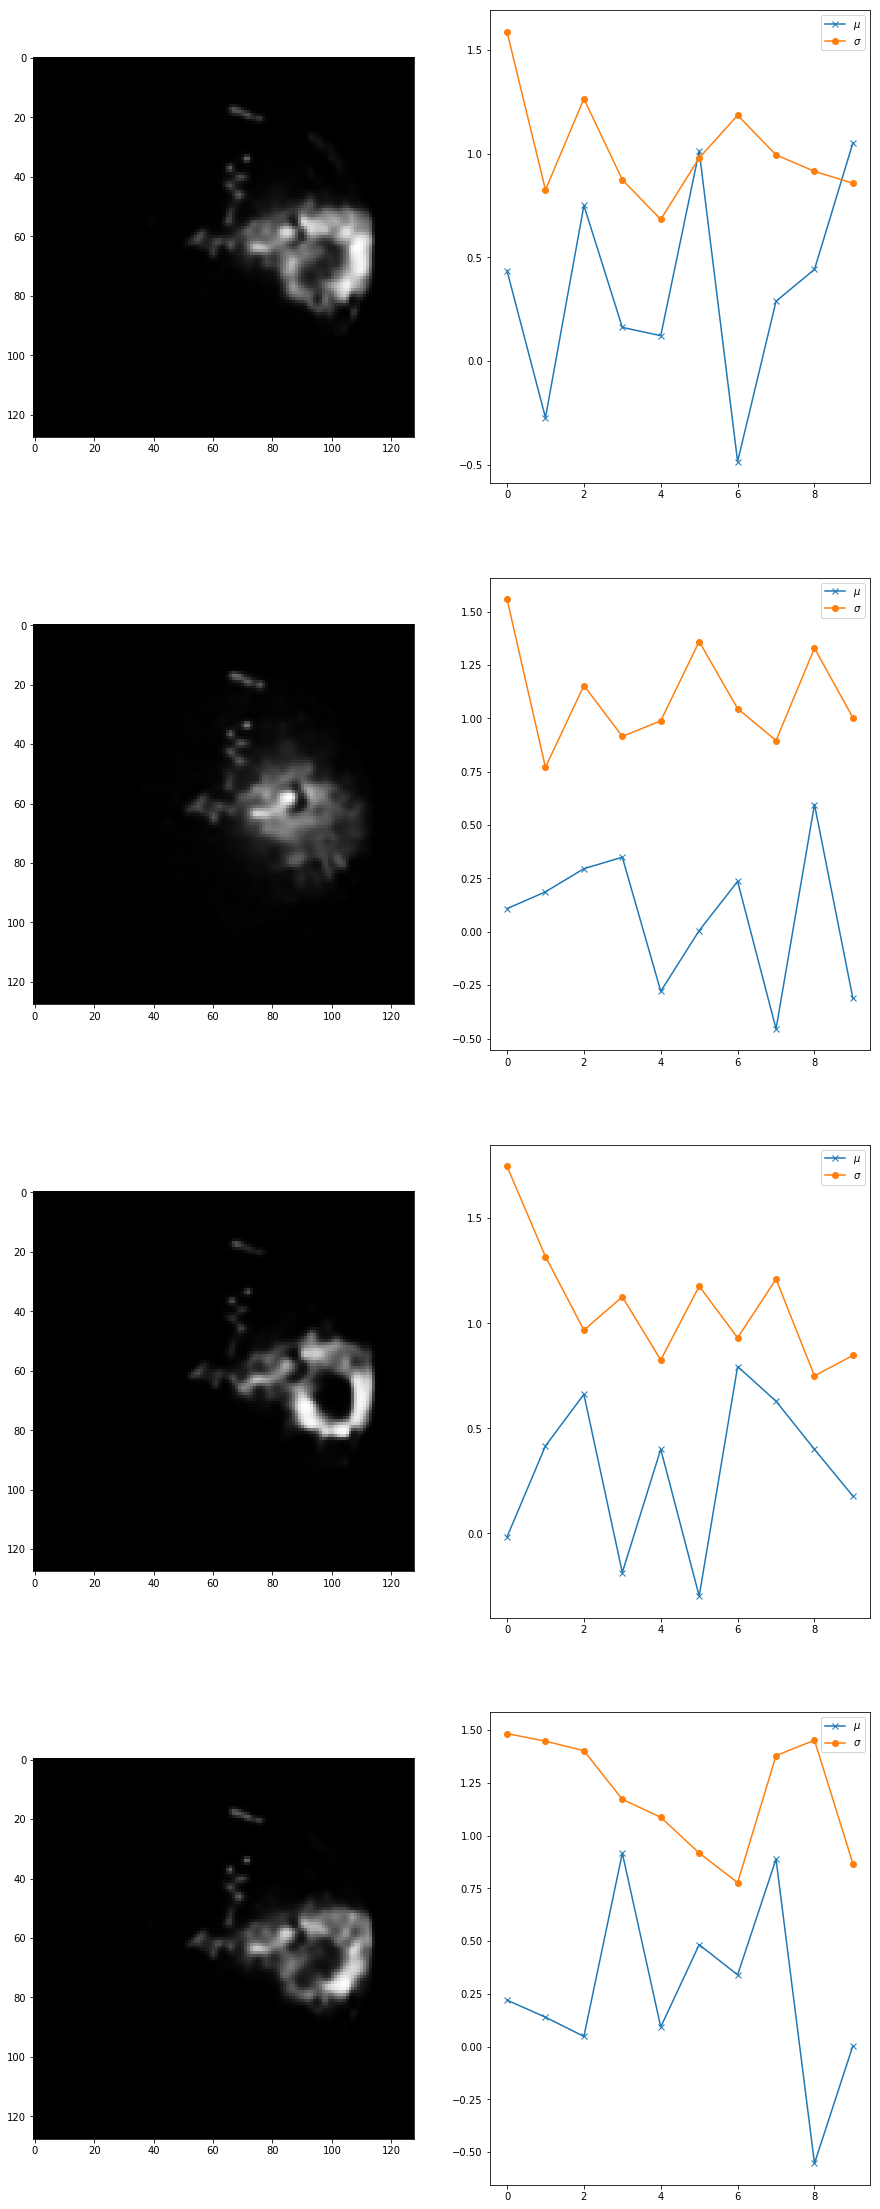

In [81]:
which_1 = [2, 11, 4, 3, 5, 6, 7]
which_2 = where_zero[30:50]


reference = 126
start = 1922
which_3 = [pairs[1923][0], pairs[1923 + 0][1],
         pairs[8981][0], pairs[8981][1],
         pairs[10279][0], pairs[10279][1]]

which_3 = [w for w in which_3 if w != reference]
which_3.append(reference)

which = which_3

n_plots = len(which)
fig, axs = plt.subplots(ncols=2, nrows=n_plots, figsize=(15, 40))

for i, ax in enumerate(axs):
    image = sigmoid(reconst[-1, which[i], :].reshape((128, 128)))
    
    latent = train_latent[:, which[i], :]
    latent_mean = np.average(latent, axis=1)
    latent_std = np.std(latent, axis=1)
    x = np.arange(latent.shape[0])
    
    ax[0].imshow(image, cmap="Greys_r")
    ax[1].plot(x, latent_mean, "x-", label=r"$\mu$")
    ax[1].plot(x, latent_std, "o-", label=r"$\sigma$")
    ax[1].legend()